In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from music21 import corpus, converter
from collections import Counter

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
# Funtion to extract the pitch histogram from a score
def extract_pitch_histogram(score):

    pitch_histogram = [0]*12

    try:

        all_notes = score.flat.notes    # Flatten the score
        total_pitches = 0

        for note in all_notes:

            if note.quarterLength < 0.05:   # For removing ornamental notes
                continue

            if note.isNote:     # for single note
                pitch_histogram[note.pitch.pitchClass] += 1
                total_pitches += 1

            elif note.isChord:      # for chord include all different pitches
                for pitch in note.pitches:
                    pitch_histogram[pitch.pitchClass] += 1
                    total_pitches += 1

        if total_pitches == 0:
            return None
        
        return [pitch_count/total_pitches for pitch_count in pitch_histogram]   # normalize to make data independent of score length
    
    except:
        return None

In [ ]:
# Function to extract interval histogram from given score
def extract_interval_histogram(score):  
    
    try:

        all_notes = score.flat.notes    # Flatten the score
        pitches = []

        for note in all_notes:
            if note.quarterLength < 0.05:   # For removing ornamental notes
                continue

            if note.isNote:
                pitches.append(note.pitch.midi)
            
            elif note.isChord:
                # Take melody line only (highest note of chord)
                pitches.append(max(pitch.midi for pitch in note.pitches))
        
        intervals = []

        for i in range(1,len(pitches)):
            interval = pitches[i] - pitches[i-1]
            # Skip intervals greater than octave
            if interval <= 12 and interval >= -12:
                intervals.append(interval)

        interval_histogram = [0]*25     # For -12 to +12 semitones

        for i in intervals:
            interval_histogram[i+12] += 1
        
        total = sum(interval_histogram)

        if total == 0:
            return None

        return [interval_count/total for interval_count in interval_histogram]      # normalize data


    except:
        return None

In [38]:
# Function to extract rhythm features from given score
def extract_rhythm_features(score,top_n=10):
    try:

        durations = {}  
        all_notes = score.flat.notes    # Flatten the score

        for note in all_notes:
            if note.quarterLength < 0.05:   # For removing ornamental notes
                continue

            duration = float(round(note.quarterLength,2))   
            durations[duration] = durations.get(duration,0) + 1

        sorted_durations = sorted(durations.items(),key = lambda x: -x[1])[:top_n]
        total = sum(dur[1] for dur in sorted_durations)

        features = []   # of the form [freq, dur, freq, dur ...]

        for dur, count in sorted_durations:
            freq = count/total
            features.extend([freq,dur])

        while len(features) < 2 * top_n:     # Fill zeros till length 2 * top_n
            features.extend([0.0,0.0])

        if not features:
            return None
        
        return features
    
    except:
        return None

In [39]:
# Make combined vector from all three histograms/features
def extract_combined_features(score):

    pitch = extract_pitch_histogram(score)
    interval = extract_interval_histogram(score)
    rhythm = extract_rhythm_features(score)

    if pitch and rhythm and interval:
        return pitch + interval + rhythm

In [40]:
# Feature Labels
feature_labels = (
    ['Pitch_' + str(i) for i in range(12)] +
    ['Interval_' + str(i-12) for i in range(25)] +
    ['DurFreq_' + str(i//2) if i%2==0 else 'DurVal_' + str(i//2) for i in range(20)]
)

In [41]:
data = []
labels = []

# Load 60 Bach files from music21 corpus 
bach_files = corpus.getComposer('bach')[:60]
for work in bach_files:
    try:
        score = corpus.parse(work)
        features = extract_combined_features(score)
        if features:
            data.append(features)
            labels.append("Bach")
    except:
        continue

In [42]:
# Load Chopin files (60)
for file in os.listdir("chopin"):
    if file.endswith(".mid") or file.endswith(".midi"):
        try:
            score = converter.parse(os.path.join("chopin", file))
            features = extract_combined_features(score)
            if features:
                data.append(features)
                labels.append("Chopin")
        except Exception as e:
            print("Error with file", file, ":", e)

In [45]:
# Count composer labels

composer_counts = Counter(labels)
print("Composer Counts:", composer_counts)

Composer Counts: Counter({'Bach': 60, 'Chopin': 60})


In [46]:
# Convert to numpy arrays
X = np.array(data)
y = np.array(labels)

# Check shape
print("Feature matrix shape:", X.shape)
print("Labels array shape:", y.shape)


Feature matrix shape: (120, 57)
Labels array shape: (120,)


In [47]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Bach : 0, Chopin : 1

# Split into Train-Val-Test

# First split : train vs temp (60% vs 40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42)

# Second split : val vs test (20% vs 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [48]:
# Train a Random Forest Classifier Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [49]:
# Validation results
val_pred = clf.predict(X_val)
print("Validation Report:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

Validation Report:
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00        12
      Chopin       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



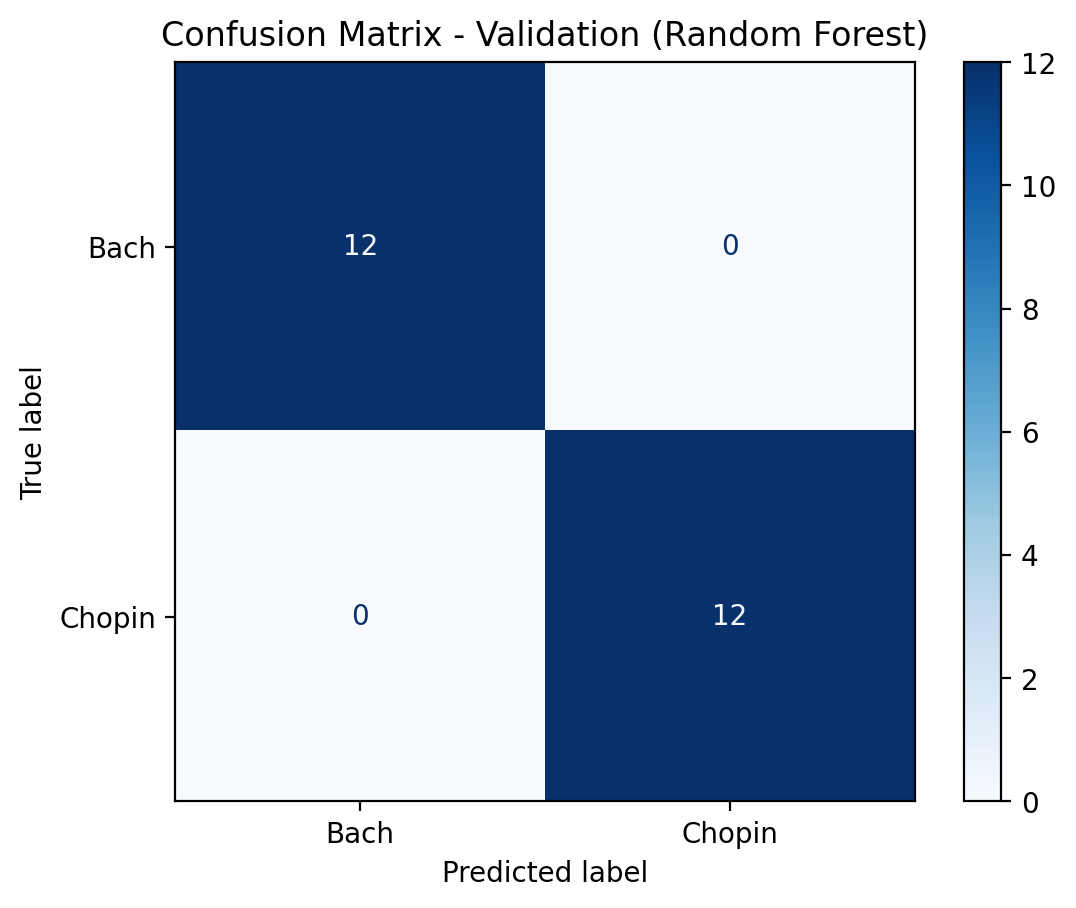

In [50]:
# Confusion matrix for val
cm_val = confusion_matrix(y_val, val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=le.classes_)
disp_val.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Validation (Random Forest)")
plt.show()

In [51]:
# Test results
test_pred = clf.predict(X_test)
print("Test Report:")
print(classification_report(y_test, test_pred, target_names=le.classes_))

Test Report:
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00        12
      Chopin       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



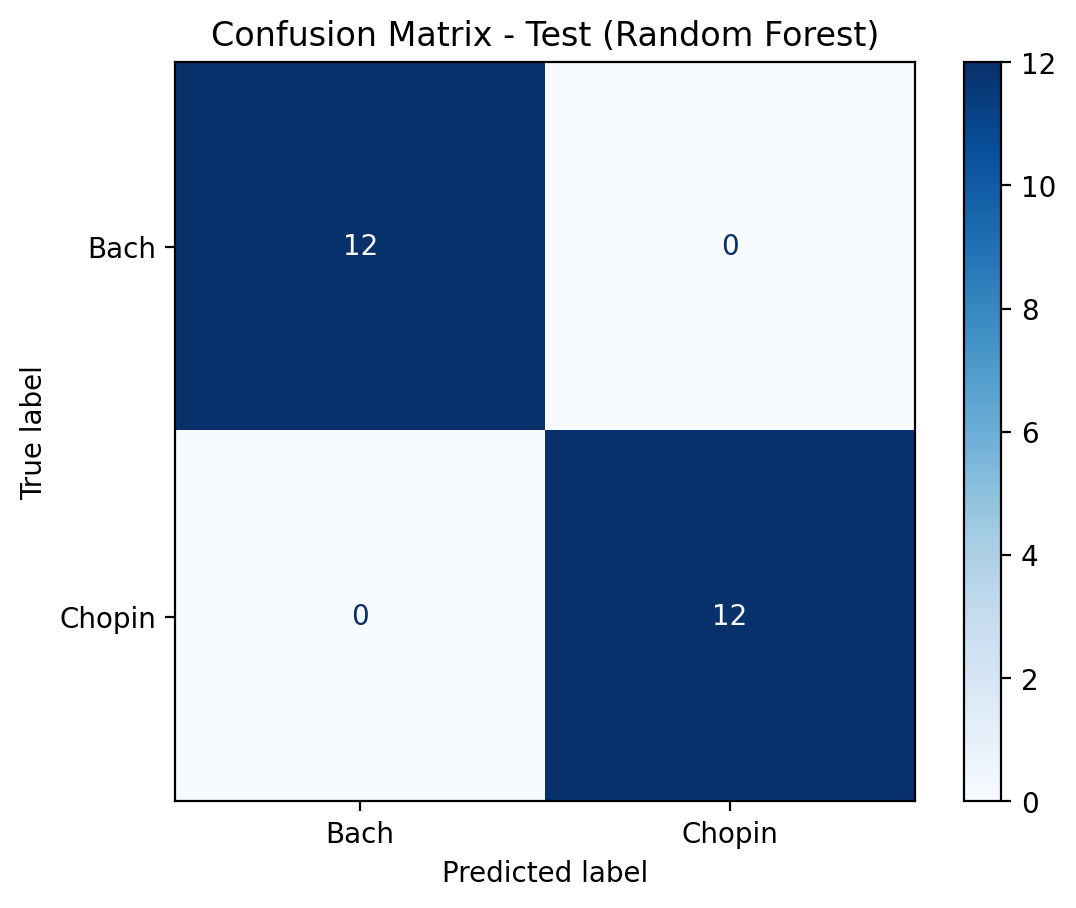

In [52]:
# Confusion matrix for test
cm_test = confusion_matrix(y_test, test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le.classes_)
disp_test.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test (Random Forest)")
plt.show()

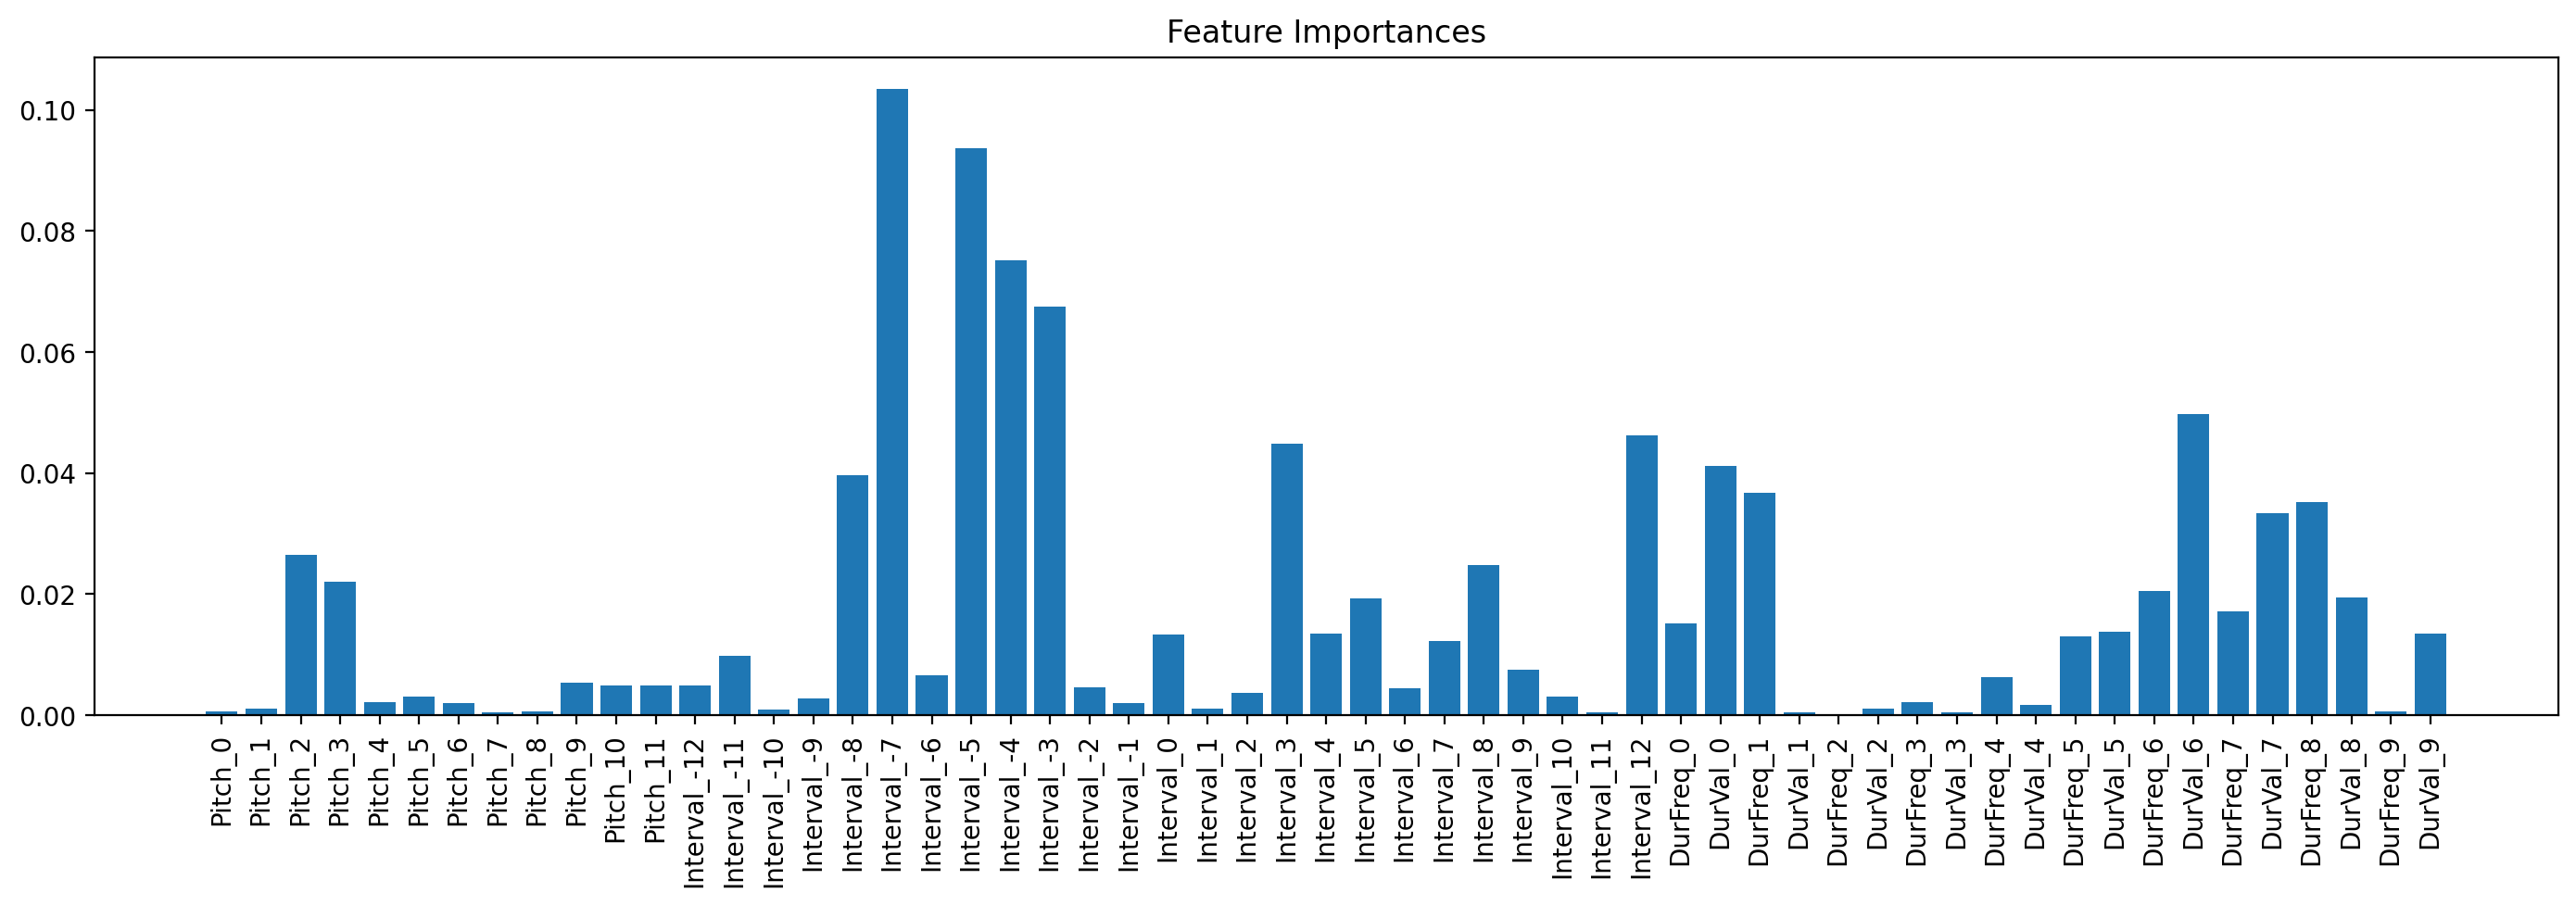

In [53]:
# Plot the feature importances
plt.figure(figsize=(14, 5))
plt.bar(feature_labels, clf.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [56]:
# Cross Validation Scores

scores = cross_val_score(clf, X, y_encoded, cv=5)
print("Cross-validation scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-validation scores: [1.         1.         1.         0.95833333 0.95833333]
Mean Accuracy: 0.9833333333333334



 Logistic Regression 


 Validation Set 

Classification Report:
              precision    recall  f1-score   support

        Bach       0.92      1.00      0.96        12
      Chopin       1.00      0.92      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



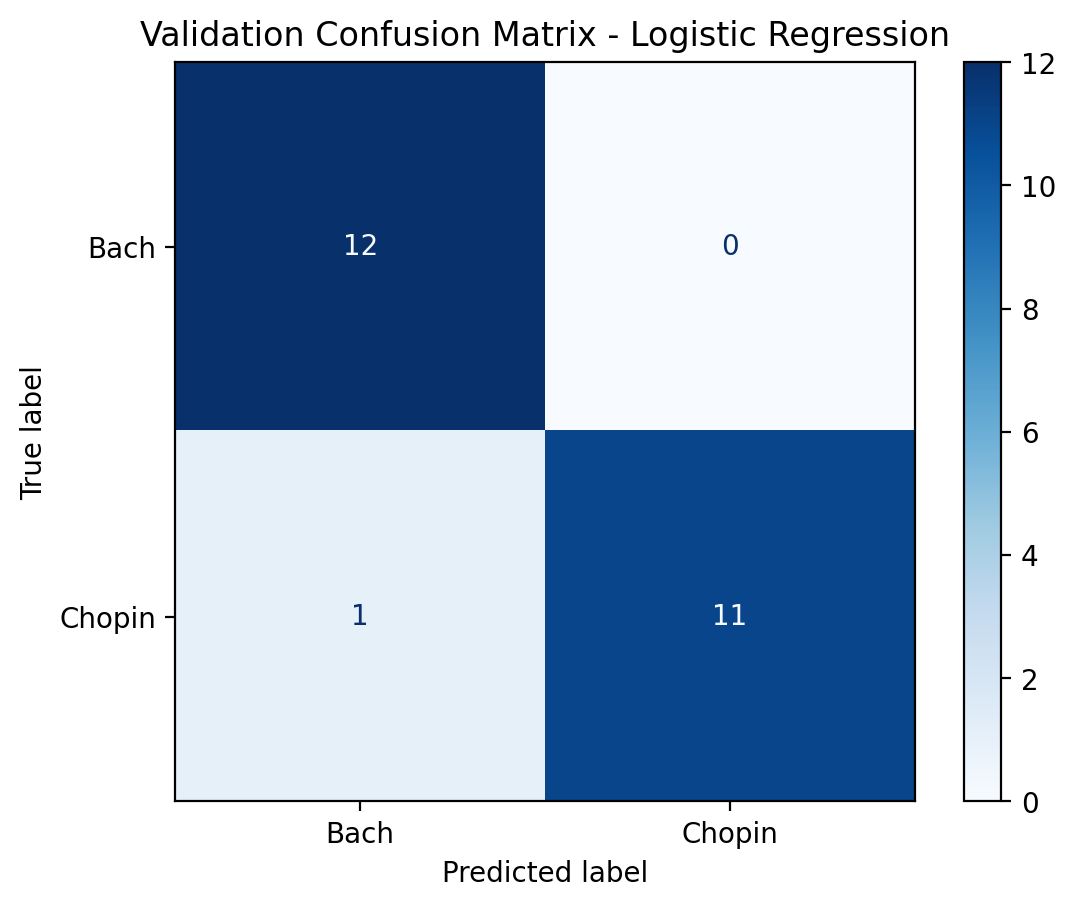


 Test Set 

Classification Report:
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00        12
      Chopin       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



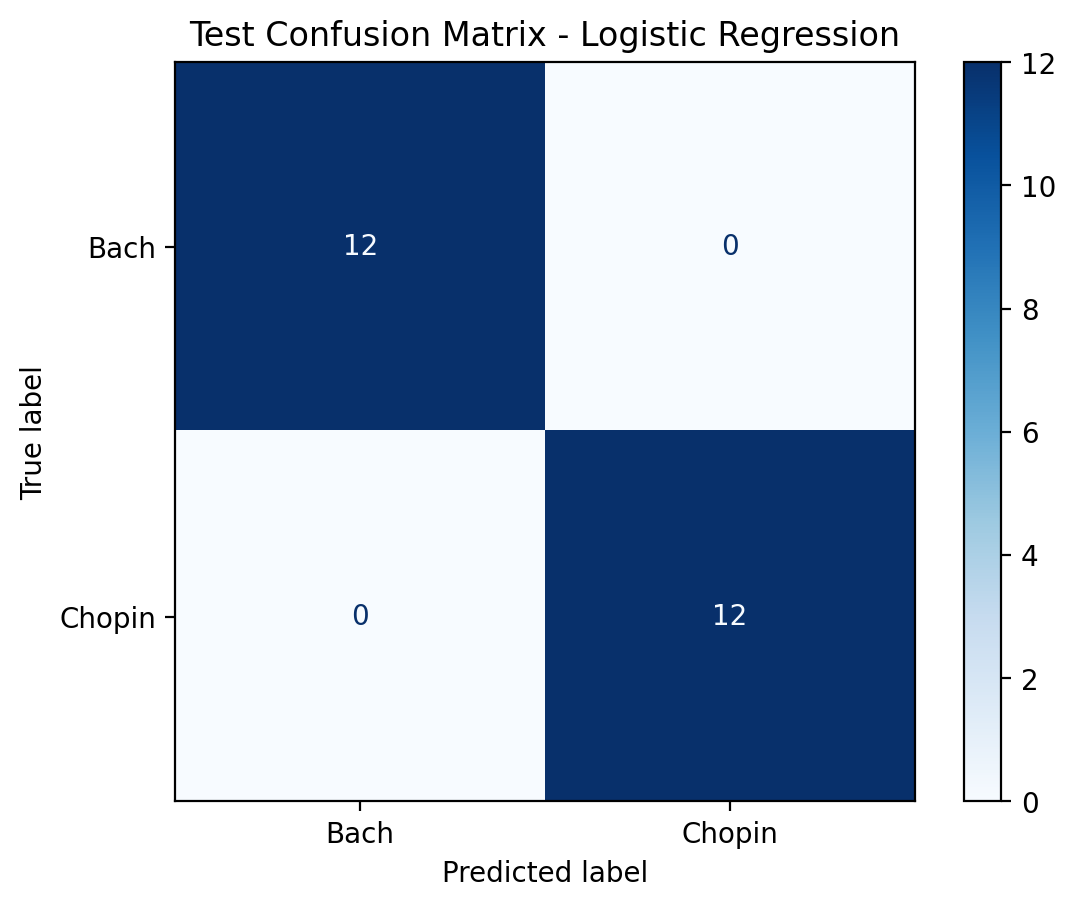


 k-NN (k=3) 


 Validation Set 

Classification Report:
              precision    recall  f1-score   support

        Bach       0.92      0.92      0.92        12
      Chopin       0.92      0.92      0.92        12

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24



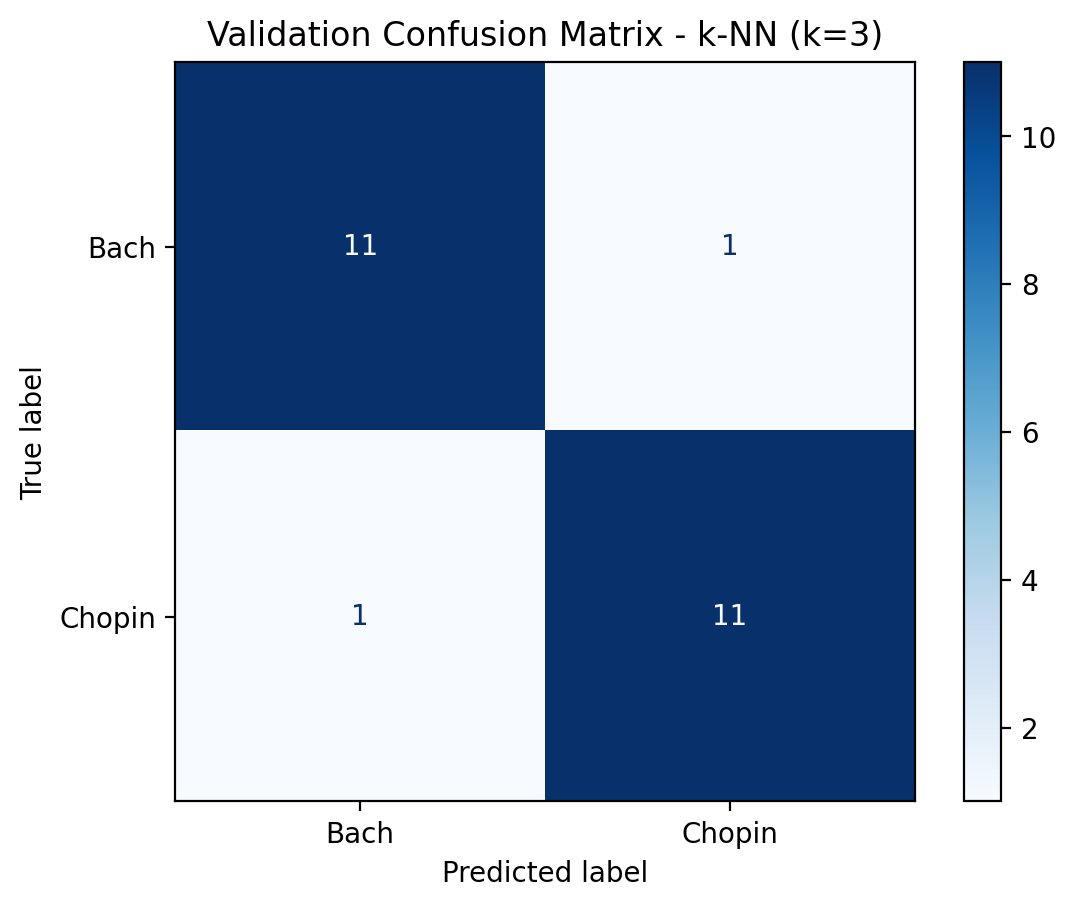


 Test Set 

Classification Report:
              precision    recall  f1-score   support

        Bach       0.92      0.92      0.92        12
      Chopin       0.92      0.92      0.92        12

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24



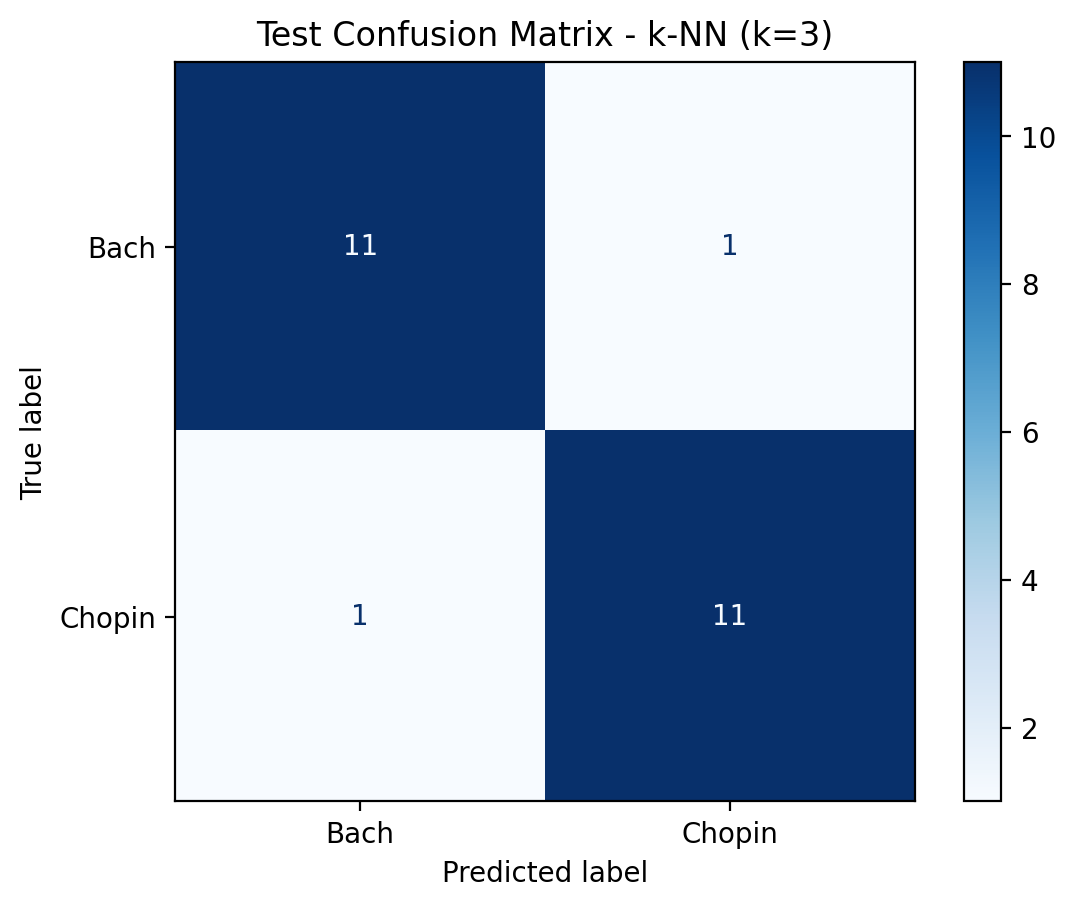


 SVM (linear) 


 Validation Set 

Classification Report:
              precision    recall  f1-score   support

        Bach       1.00      0.92      0.96        12
      Chopin       0.92      1.00      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



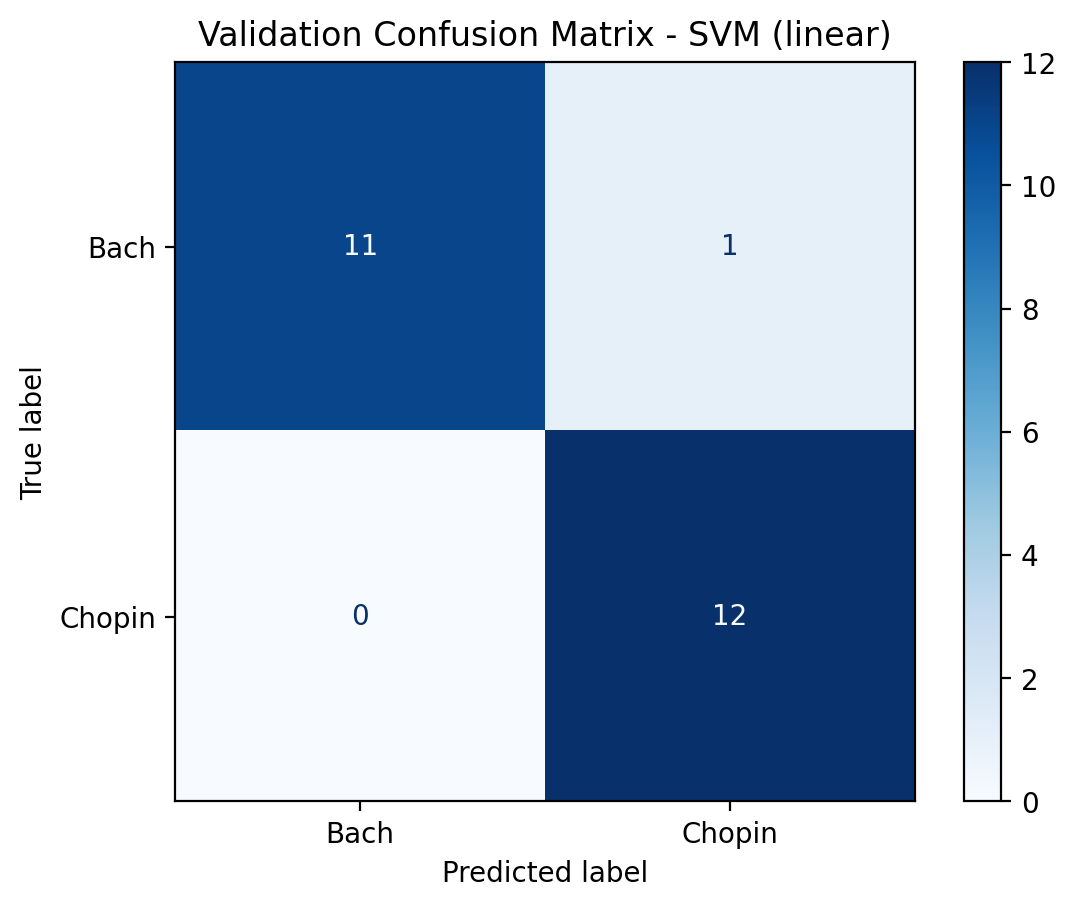


 Test Set 

Classification Report:
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00        12
      Chopin       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



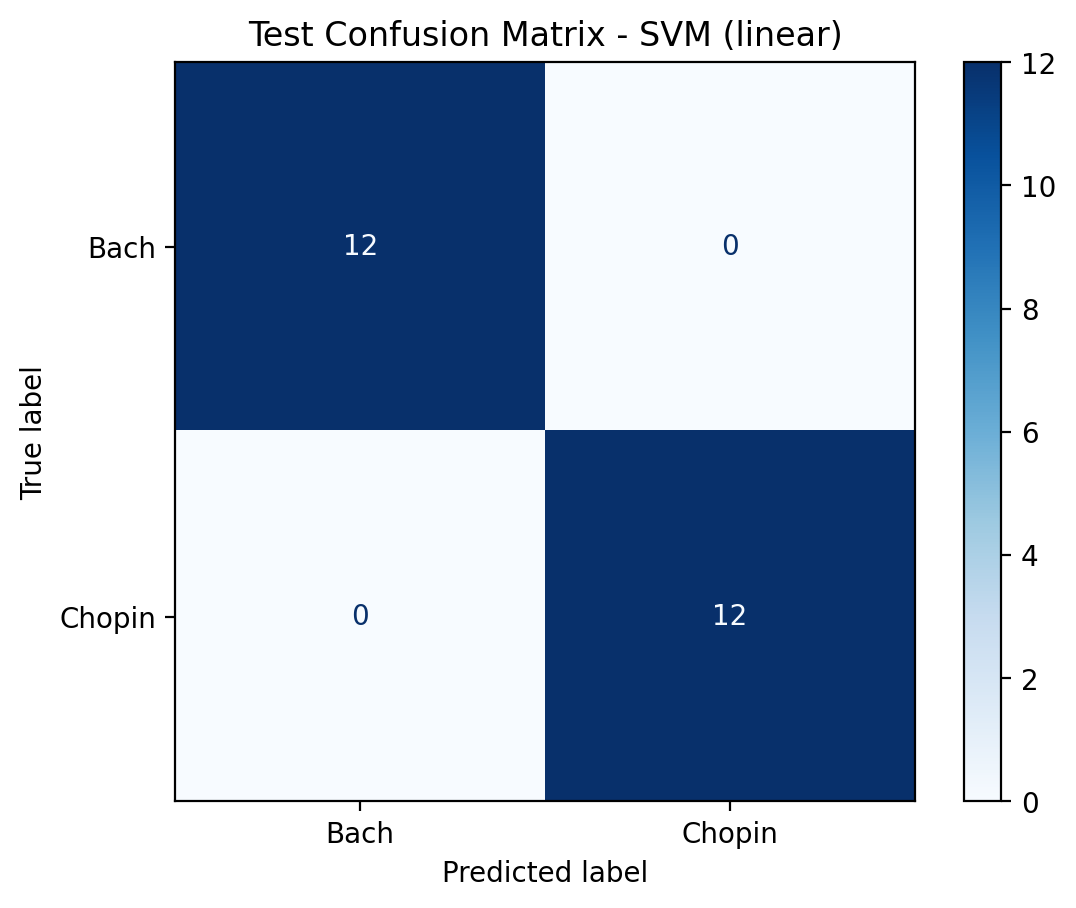


Cross-Validation (5-fold)

Logistic Regression Mean Accuracy: 0.908
k-NN (k=3) Mean Accuracy: 0.908
SVM (linear) Mean Accuracy: 0.958


In [57]:
# Training other models on composer data

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "k-NN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "SVM (linear)": SVC(kernel='linear'),
}

for name, model in models.items():
    print(f"\n {name} \n")
    model.fit(X_train, y_train)     # Train model

    # Evaluate on val and test
    for split_name, X_split, y_split in [("Validation", X_val, y_val), ("Test", X_test, y_test)]:
        preds = model.predict(X_split)
        print(f"\n {split_name} Set \n")
        print("Classification Report:")
        print(classification_report(y_split, preds, target_names=le.classes_))

        # Confusion matrix
        cm = confusion_matrix(y_split, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f"{split_name} Confusion Matrix - {name}")
        plt.show()

# Cross-validation scores
print("\nCross-Validation (5-fold)\n")
for name, model in models.items():
    scores = cross_val_score(model, X, y_encoded, cv=5)
    print(f"{name} Mean Accuracy: {scores.mean():.3f}")

